# Fairness Benchmark

This notebook plots the suboptimality performance of various optimization algorithms against demographic/statistical parity on the Diabetes 130-Hospitals (`diabetes`) and Adult Census (`acsincome`) benchmarks.

In [1]:
import os
import sys
import pickle
import pandas as pd
import numpy as np
import torch
from torch.nn.functional import binary_cross_entropy_with_logits
from scipy.stats import ks_2samp

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("..")
from src.utils.io import get_path, var_to_str, load_results
from src.utils.data import load_dataset

from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio, equalized_odds_difference, equalized_odds_ratio
from tqdm import tqdm

In [2]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['xtick.labelsize'] = 26
mpl.rcParams['ytick.labelsize'] = 26
mpl.rcParams["axes.labelsize"] = 34
mpl.rcParams['legend.fontsize'] = 32
mpl.rcParams['axes.titlesize'] = 32
mpl.rcParams['text.usetex'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [3]:
l2_reg = 1.0
shift_cost = 1.0
result_dir = "../results"

In [4]:
plot_cfgs = [
    {
        "optimizer": "sgd",
        "label": "SGD",
        "color": "black",
        "linestyle": "solid",
        "marker": ".",
    },
    {
        "optimizer": "saddlesaga",
        "label": "SaddleSAGA",
        "color": "goldenrod",
        "linestyle": "solid",
        "marker": "s",
    },
    {
        "optimizer": "lsvrg",
        "label": "LSVRG",
        "color": "cadetblue",
        "linestyle": "solid",
        "marker": "o",
    },
    {
        "optimizer": "prospect",
        "label": "Prospect (Ours)",
        "color": "tab:red",
        "linestyle": "solid",
        "marker": "^",
    },
]

In [5]:
def get_suboptimality(
    dataset, model_cfg, train_loss, eps=1e-9, out_path="../results/"
):
    init_loss = train_loss[0]
    path = get_path([dataset, var_to_str(model_cfg)], out_path=out_path)
    f = os.path.join(path, "lbfgs_min_loss.p")
    min_loss = pickle.load(open(f, "rb"))
    subopt = (train_loss - min_loss + eps) / (init_loss - min_loss)
    return subopt

def get_iterates(dataset, objective, optimizer, seed=1):
  
    loss = "squared_error" if dataset == "acsincome" else "binary_cross_entropy"
    model_cfg = {
        "objective": objective,
        "l2_reg": l2_reg,
        "loss": loss,
        "n_class": None,
        "shift_cost": shift_cost
    }

    path = get_path([dataset, var_to_str(model_cfg), optimizer], out_path=result_dir)
    f = os.path.join(path, f"iterates_{seed}.p")
    return [iterate.detach() for iterate in pickle.load(open(f, "rb"))]

def get_dp(X,y,dataset,column, optimizer, objective, metric="difference",df=None):
    iterates = get_iterates(dataset, objective, optimizer)
    out = []
    for i, w in tqdm(enumerate(iterates)):
        # print(X.shape)
        # print(w.shape)
        # print(X)
        # print(w)
        y_pred = (X @ w >= 0).int()
        if metric == "difference":
            out.append(demographic_parity_difference(y, y_pred, sensitive_features=list(df[column])))
        elif metric == "ratio":
            out.append(demographic_parity_ratio(y, y_pred, sensitive_features=list(df[column])))
    return out

def get_ks_dist(y_pred, y_true):
    out = ks_2samp(y_pred, y_true, method="asymp")
    return out.statistic

def get_dist_groups(df,column, optimizer, objective, dataset="acsincome", method="ks"):
    iterates = get_iterates(dataset, objective, optimizer)
    groups = list(df[column].unique())

    dist_groups = []

    for i, w in tqdm(enumerate(iterates)):
        y_pred = (X @ w).numpy()
        ypd = pd.Series(y_pred)
        y_groups = [(ypd.loc[df[column] == group]).to_numpy() for group in groups]
        if method == "ks":
            dist_groups.append(np.array([get_ks_dist(y_pred, y_group) for y_group in y_groups]))
        elif method == "wasserstein":
            raise Exception("Wasserstein not defined!")
        #     dist_groups.append(np.array([wasserstein_dist(y_pred, y_group) for y_group in y_groups]))

    return np.array(dist_groups)

def plot_ax(ax, seeds, objective, plot_cfg, dataset, epoch_len=None, n=4000, downsample=1, max_epoch=32, markersize=8, out_path="../results/"):
    optimizer = plot_cfg['optimizer']
    model_cfg = {
        "objective": objective, 
        "l2_reg": l2_reg, 
        "loss": "binary_cross_entropy" if dataset == "diabetes" else "squared_error", 
        "n_class": None,
        "shift_cost": shift_cost
    }
    for seed in seeds:
        filename = plot_cfg["optimizer"]
        path = get_path([dataset, var_to_str(model_cfg), filename], out_path=out_path)
        df = pickle.load(open(os.path.join(path, "best_traj.p"), "rb"))
        train_loss = torch.tensor(df["average_train_loss"])
        epochs = torch.arange(len(train_loss))
        subopt = get_suboptimality(
            dataset, model_cfg, train_loss, out_path=result_dir
        )
        if optimizer == "lsvrg":
            x = epochs * 2
        elif optimizer in ["sgd", "srda"]:
            x = epochs
        else:
            x = epochs
        idx = (x <= max_epoch)
        ax.plot(
            x[idx][::downsample], 
            subopt[idx][::downsample], 
            label=plot_cfg['label'], 
            color=plot_cfg['color'],
            marker=plot_cfg['marker'],
            markersize=markersize
        )

<bound method NDFrame.head of      Unnamed: 0  gender             race
0         12265  Female         Hispanic
1         76406  Female        Caucasian
2         28494  Female        Caucasian
3         52920  Female        Caucasian
4         36661  Female  AfricanAmerican
..          ...     ...              ...
995       24986  Female  AfricanAmerican
996       90775    Male        Caucasian
997      100493  Female        Caucasian
998       51078  Female        Caucasian
999       60473  Female        Caucasian

[1000 rows x 3 columns]>


32it [00:00, 32.84it/s]


sp mean sgd 0.06864823169727327
sp std sgd 0.0005628517823639933


32it [00:00, 33.18it/s]


sp mean saddlesaga 0.017335111746768904
sp std saddlesaga 0.0008597702992412192


32it [00:01, 27.23it/s]


sp mean lsvrg 0.016288954686614888
sp std lsvrg 0.001562643628005468


32it [00:01, 21.18it/s]


sp mean prospect 0.016021790921253
sp std prospect 0.0


32it [00:01, 23.88it/s]


sp mean sgd 0.06864823169727327
sp std sgd 0.0005628517823639933


32it [00:01, 25.01it/s]


sp mean saddlesaga 0.016209408182040985
sp std saddlesaga 0.0005628517823639601


32it [00:01, 24.11it/s]


sp mean lsvrg 0.016288954686614888
sp std lsvrg 0.001562643628005468


32it [00:01, 24.39it/s]


sp mean prospect 0.016021790921253
sp std prospect 0.0


64it [00:02, 29.55it/s]
64it [00:01, 37.38it/s]
64it [00:01, 47.40it/s]
64it [00:01, 36.94it/s]
64it [00:01, 49.90it/s]
64it [00:01, 44.81it/s]
64it [00:01, 36.98it/s]
64it [00:01, 43.21it/s]


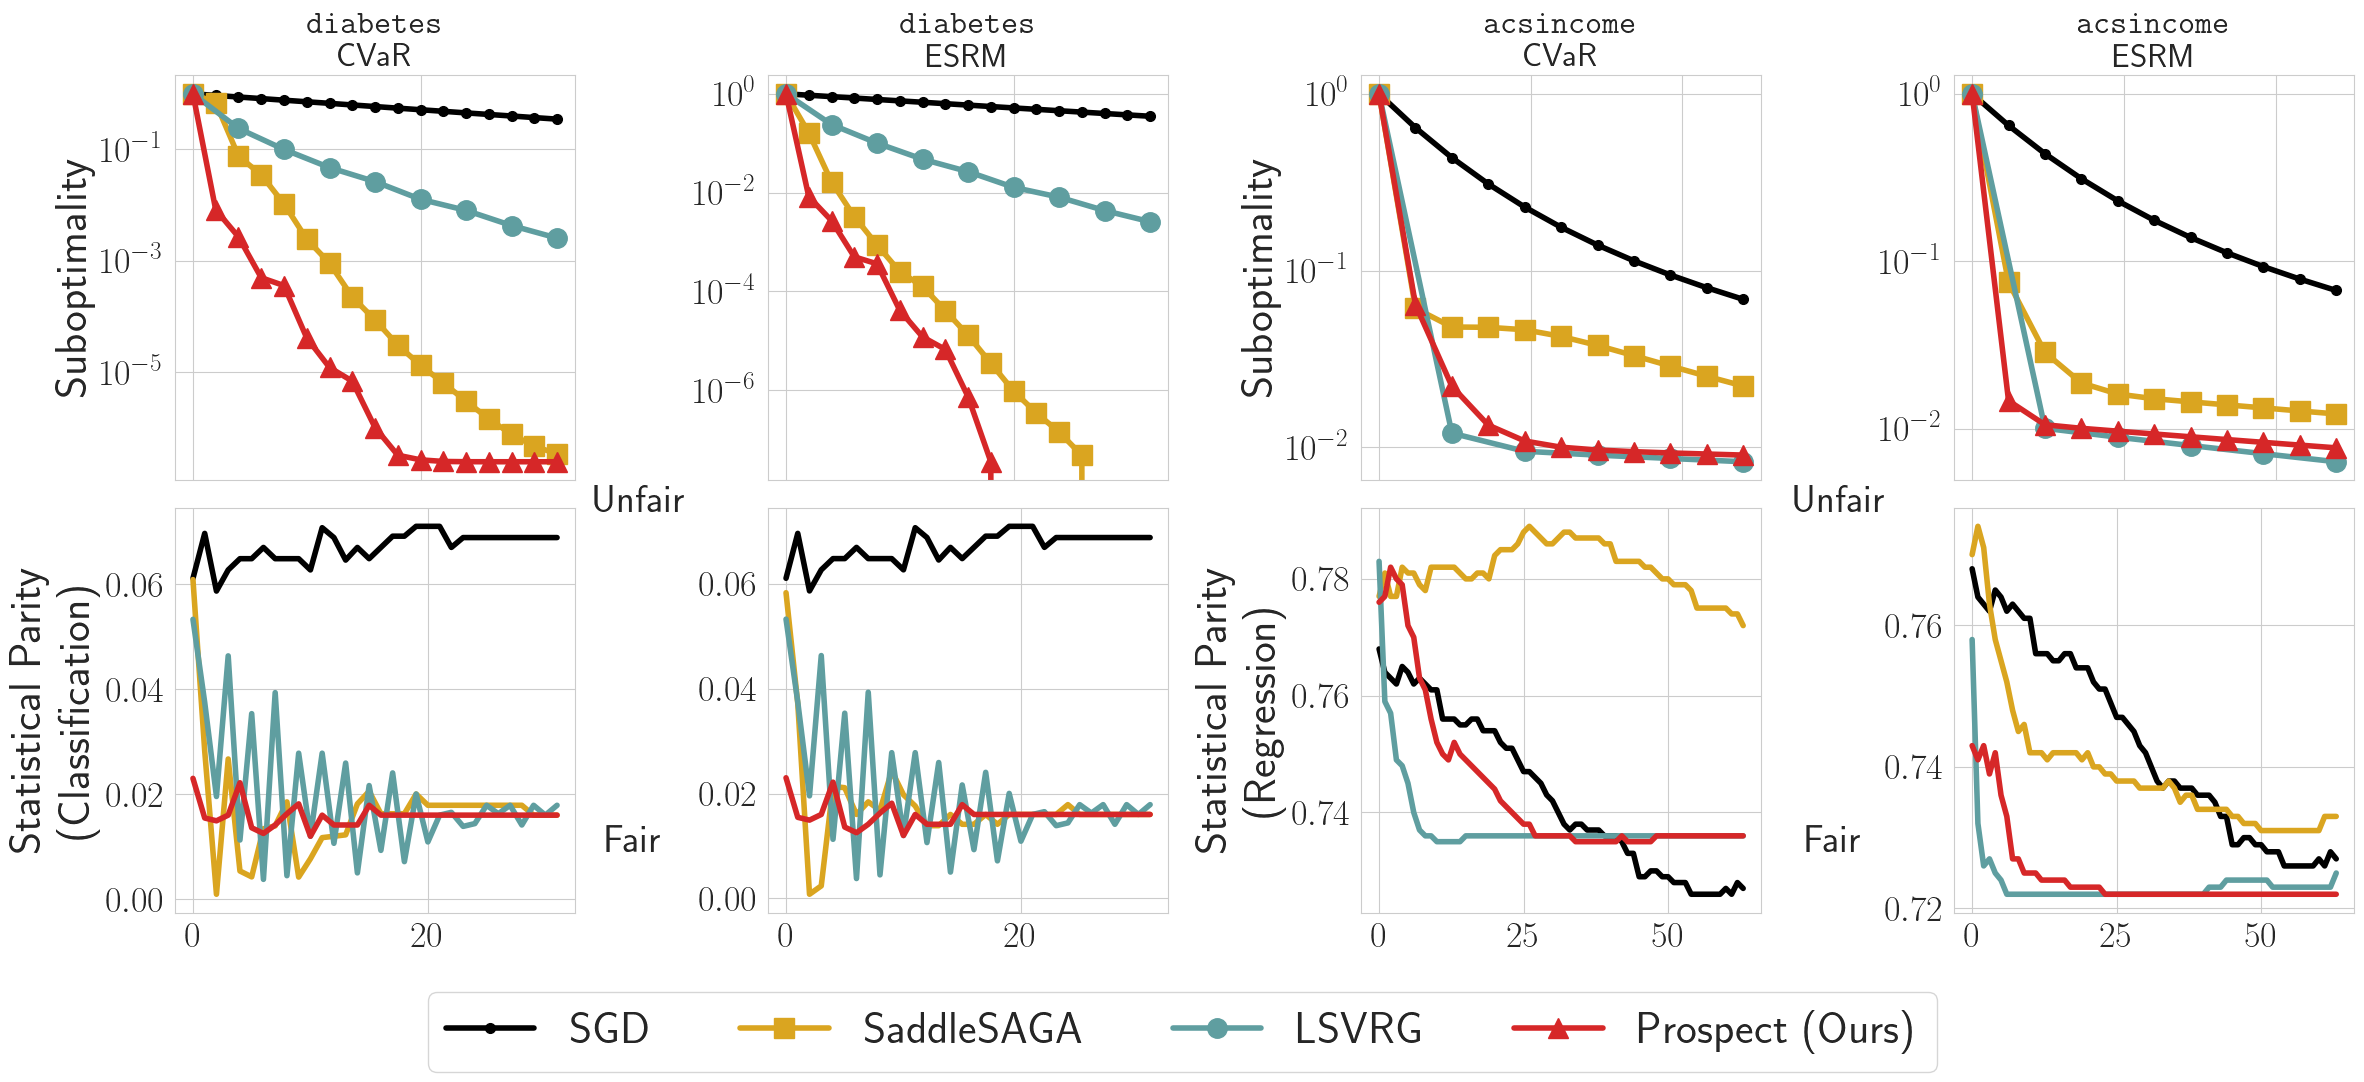

In [6]:
## demographic parity
from sklearn.preprocessing import LabelEncoder
dataset = "diabetes"

X = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/X_test.npy"))
y = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/y_test.npy")).double()

# print(X.shape)
# print(y.shape)

df = pd.read_csv(f"../data/{dataset}/metadata_te.csv")
# print(df.gender.unique())
# print(df.race.unique())
print(df.head)
# sex_tensor = torch.tensor(pd.get_dummies(df["gender"]).values, dtype=torch.float64)
# rac1p_tensor = torch.tensor(pd.get_dummies(df["race"]).values, dtype=torch.float64)

le_gender = LabelEncoder()
le_race = LabelEncoder()

gender_encoded = le_gender.fit_transform(df["gender"])
race_encoded = le_race.fit_transform(df["race"])

# Convert to tensors
gender_tensor = torch.tensor(gender_encoded, dtype=torch.float64).unsqueeze(1)
race_tensor = torch.tensor(race_encoded, dtype=torch.float64).unsqueeze(1)

# Concatenate the new attributes to X
X1 = torch.cat((X, gender_tensor, race_tensor), dim=1)

objectives = ["superquantile", "esrm"]
column = "gender"
metric = "difference"

sns.set_style("whitegrid")

fig, ax = plt.subplots(2, len(objectives) * 2, figsize=(12 * len(objectives), 10))

obj_names = ["CVaR", "ESRM", "CVaR", "ESRM"]
for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        optimizer = plot_cfg["optimizer"]
        yy = get_dp(X1,y,dataset,column, optimizer, objective, metric=metric,df=df)
        xx = np.arange(len(yy))

        print(f"sp mean {optimizer}", np.array(yy)[-10:].mean())
        print(f"sp std {optimizer}", np.array(yy)[-10:].std())

        markersize = 14
        downsample = 2
        ax[1, j].plot(xx, yy, label=plot_cfg['label'], color=plot_cfg['color'])
        # ax[1, j].set_xticklabels([])
        ax[0, j].set_title(r"{\texttt{diabetes}}" + f"\n{obj_names[j]}", fontsize=24)

        plot_ax(ax[0, j], [1], objective, plot_cfg, dataset, max_epoch=32, downsample=downsample, markersize=markersize)
        ax[0, j].set_yscale("log")
        ax[0, j].set_xticklabels([])

ax[1, 0].set_ylabel("Statistical Parity\n(Classification)", fontsize=32)
ax[0, 0].set_ylabel(f"Suboptimality", fontsize=32)

# acsincome

dataset = "acsincome"

X = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/X_test.npy"))
y = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/y_test.npy")).double()

# print(X.shape)
# print(y.shape)

df = pd.read_csv(f"../data/{dataset}/metadata_te.csv")
# print(df.SEX.unique())
# print(df.RAC1P.unique())

objectives = ["superquantile", "esrm", "superquantile", "esrm"]
column = "RAC1P"
# metric = "ratio"
dataset = "acsincome"

obj_names = ["CVaR", "ESRM", "CVaR", "ESRM"]
for j, objective in enumerate(objectives):
    if j > 1:
        for plot_cfg in plot_cfgs:
            optimizer = plot_cfg["optimizer"]
            group_loss = get_dist_groups(df,column, optimizer, objective)
            yy = np.max(group_loss, axis=1) # worst distance
            xx = np.arange(len(yy))

            markersize = 14
            downsample = 6
            ax[1, j].plot(xx, yy, label=plot_cfg['label'], color=plot_cfg['color'])
            # ax[1, j].set_xticklabels([])
            ax[0, j].set_title(r"{\texttt{acsincome}}" + f"\n{obj_names[j]}", fontsize=24)

            plot_ax(ax[0, j], [1], objective, plot_cfg, dataset, max_epoch=64, downsample=downsample, markersize=markersize)
            ax[0, j].set_yscale("log")
            ax[0, j].set_xticklabels([])


# arrows
fig.text(0.26, 0.13, "Fair", fontsize=28)
fig.text(0.255, 0.47, "Unfair", fontsize=28)
fig.text(0.76, 0.13, "Fair", fontsize=28)
fig.text(0.755, 0.47, "Unfair", fontsize=28)

ax[1, 2].set_ylabel("Statistical Parity\n(Regression)", fontsize=32)
ax[0, 2].set_ylabel(f"Suboptimality", fontsize=32)
plt.tight_layout(pad=2.0)
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='center',
            bbox_to_anchor=(0.5, -0.05), ncol=4)

plt.savefig(f"../figures/fairness_training_curves.pdf", bbox_inches="tight")
plt.show()